In [ ]:
# default_exp load_data
%reload_ext autoreload
%autoreload 2
!date

Thu Jul  8 07:18:21 PDT 2021


# Load data
> Prepare photons and exposure, given a source 

This module defines the function `load_source_data`.

Since the photon data now has exposure (column `tau`), the exposure is redundant.

In [ ]:
#export
import pickle, healpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wtlike.config import (Config, UTC, MJD)
from wtlike.effective_area import EffectiveArea
from wtlike.sources import PointSource

In [ ]:
# export
def binned_exposure(config, exposure, time_edges):
    """Bin the exposure

    - time_bins: list of edges, as an interleaved start/stop array


    returns  array of exposure integrated over each time bin, times 1e-9
    it is interleaved, client must apply [0::2] selection.

    """

    # get exposure calculation
    exp   =exposure.exp.values
    estart= exposure.start.values
    estop = exposure.stop.values

    # determine bins,

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_edges)

    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]

    # difference is exposure per interval: normalize it here
    bexp = np.diff(cum)
#     if config.verbose>1:
#         print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
    return bexp

In [ ]:
# export
def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source

    - source : a PointSource object
    - week : dict with
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data

    Returns a DF with
    - `band` index,
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing
    - `radius` distance in deg from source direction
    """

    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix

    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)

    if sum(incone)<2:
        if config.verbose>1:
            print(f'\nWeek starting {UTC(MJD(tstart))} has 0 or 1 photons')
        return

    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone].copy()

    if 'trun' in dfc:
        time = dfc.run_id.astype(float) + dfc.trun * config.offset_size
    else:
        # old: convert  to float, add tstart, convert to MJD
        time = np.array(dfc.time, float)+tstart
    dfc.loc[:,'time'] = MJD(time)

    # assemble the DataFrame, remove those outside the radius
    out_df = dfc

    # make sure times are monotonic by sorting (needed since runs not in order in most
    #  week-files after March 2018)
    out_df = dfc.sort_values(by='time')

    if config.verbose>2:
        print(f'selected photons:\n{out_df.head()}')

    return out_df

In [ ]:
# export

def weighted_exposure(config,  livetime, pcosine):
    """return a weighted exposure calculated for each pair in livetime and cosines arrays

    - config -- access to `base_spectrum`, used to weight the exposue
    """
    from scipy.integrate import simps
    assert len(livetime)==len(pcosine), 'expect equal-length arrays'

    # get a set of energies and associated weights from a trial spectrum

    emin,emax = config.energy_range
    loge1=np.log10(emin); loge2=np.log10(emax)

    edom=np.logspace(loge1, loge2, int((loge2-loge1)*config.bins_per_decade+1))
    if config.verbose>1:
        print(f'Calculate exposure using the energy domain'\
              f' {emin}-{emax} {config.bins_per_decade} bins/decade' )
    base_spectrum = eval(config.base_spectrum) #lambda E: (E/1000)**-2.1
    assert base_spectrum(1000)==1.
    wts = base_spectrum(edom)

    # effective area function
    ea = EffectiveArea(file_path=config.wtlike_data/'aeff_files')

    # a table of the weighted for each pair in livetime and pcosine arrays
    rvals = np.empty([len(wts),len(pcosine)])
    for i,(en,wt) in enumerate(zip(edom,wts)):
        faeff,baeff = ea([en],pcosine)
        rvals[i] = (faeff+baeff)*wt

    aeff = simps(rvals,edom,axis=0)/simps(wts,edom)
    return (aeff*livetime)

def sc_data_selection(config, source, week):
    
    """
    Return a DF with the S/C data for the source direction, wtih cos theta and zenith cuts
    
    columns:
    - start, stop, livetime -- from the FT2 info
    - cos_theta -- angle between bore and direction 
    - exp -- effective area at angle wighted by a default spectral function, times livetime
 
    """
    df = week['sc_data']

    # calculate cosines with respect to sky direction
    sc = source
    ra_r,dec_r = np.radians(sc.ra), np.radians(sc.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    pcosines = cosines(df.ra_scz,    df.dec_scz)
    zcosines = cosines(df.ra_zenith, df.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (pcosines >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = df.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame(
        dict(
            start=df.start[mask],
            stop=df.stop[mask],
            livetime=livetime,
            cos_theta=pcosines[mask],
            exp=weighted_exposure(config, livetime, pcosines[mask]),
        ))


In [ ]:
# export
class ExposureMan(object):
    """
    Process a week    
    """
    

    def __init__(self, config, source, week_file, carry_in=np.zeros(32)): 
        """
        
        """
        with open(week_file, 'rb') as inp:
            week = pickle.load(inp)
        pdf = week['photons']
        edf = week['sc_data']
        self.start = MJD(week['tstart'])
        self.config = config
        # note default carry_out is set 
        self.carry_in=self.carry_out=carry_in
        if config.verbose>1:
            print(f'Opened week file "{week_file.name}" of {UTC(self.start)}')
            print(f'\tFound {len(pdf):,} photons, {len(edf):,} SC entries)')
        
        self.sc_df = sc_df = sc_data_selection(config, source, week)
        
        # interleaved start/stop 
        self.stime = np.empty(2*len(sc_df.start))
        self.stime[0::2]=sc_df.start.values
        self.stime[1::2]=sc_df.stop.values
        assert np.all(np.diff(self.stime)>=0), 'Time-ordering failure'
        
        Aeff = EffectiveArea(file_path=config.wtlike_data/'aeff_files')
        self.lt = sc_df.livetime.values
        self.ct = sc_df.cos_theta.values
        
        # create 2-d array of expsoure (A*t), band x S/C time bin
        E = np.array( [Aeff(e, self.ct) * self.lt  for e in config.energy_bins] ).reshape(32, len(self.lt))
        self.CAT = np.cumsum( np.insert(E, 0, values=carry_in, axis=1), axis=1)
    
        pdf = _get_photons_near_source(config,source, week)
        if pdf is None or len(pdf)<3 :
            self.photons = None
        else:
            # set weights from the weight table, removing those with no weight            
            # add_weights(config, source, pdf )
            assert pdf is not None and len(pdf)>0
            
            pdf = source.wtman.add_weights(pdf)
            
            # finally set the time and the exposure per remaining photons
            self.photons = self.photon_exposure( pdf )
            
    def photon_exposure(self, pdf):
        
        # construct the time from the run number and offset
        ptime = MJD(pdf.run_id.astype(float) + pdf.trun * self.config.offset_size)
        pdf.loc[:,'time'] = ptime

        # select the subset with exposure info
        tk = np.searchsorted(self.stime, ptime)
        good_exp = np.mod(tk,2)==1
        pdfg = pdf[good_exp].copy()
        if len(pdfg)==0:
            return None
        pdfg.drop(columns=['trun'], inplace=True)
        pdfg.loc[:,'tau']= np.nan
        # time edges-- same for each band
        xp = np.append(self.stime[0::2],self.stime[-1]) 
        
        carry_out = self.CAT[:,-1].copy() #set to accumulate total if no events

        for bid in range(32):
            bsel = pdfg.band==bid
            if sum(bsel)==0: continue
            #print('band', bid, sum(bsel))
            
            # interpolate the cumulative exposure for this band
            fp = self.CAT[bid]                        
            t = np.interp( pdfg[bsel].time.values, xp, fp)
            
            # diff to get the exposure per photon 
            # note that fp[0] should have the previous carry
            e = np.diff (np.insert(t, 0, self.carry_in[bid]) ) 
            pdfg.loc[bsel,'tau'] = e
            
            # get unused exposure
            carry_out[bid] = pass_on = fp[-1]-t[-1]
            #print(f'** pass on {pass_on:.1f}, ratio  {pass_on/fp[-1]:.3f}')
            
        # now set for output
        self.carry_out = carry_out
        return pdfg
    
    def hist_spacecraft(self):
        self.sc_df.hist('livetime cos_theta exp'.split(), bins=100, layout=(1,3), figsize=(12,3));
        
    def hist_photons(self):
        self.photons.hist('band time tau'.split(), bins=100, log=True, figsize=(12,3), layout=(1,3));
        
    def plot_exposure(self, ax=None, **kwargs):
        """
        """
        energies = self.config.energy_bins
        plt.rc('font', size=14)
        fig, ax = plt.subplots(figsize=(8,4)) if ax is None else (ax.figure, ax)
        added = self.CAT[:,-1] - self.CAT[:,0]
        ax.semilogx(energies/1e3, added[0::2]/1e6, 'og',label='Front');
        ax.semilogx(energies/1e3, added[1::2]/1e6, 'D',color='orange', label='Back');
        ax.legend(); ax.grid(alpha=0.5)
        kw = dict(xlabel='Energy (GeV)', ylabel=r'$\mathrm{Total\  (cm^2\ Ms)}$', 
                  title=f'Exposure per band for week of {UTC(self.start)[:10]}',
                  xlim=(0.1,1e3), ylim=(0,None))
        kw.update(kwargs)
        ax.set(**kw)
        
    def plot_photon_exposure(self, ax=None, **kwargs):
        """
        """
        pt = self.photons.pivot_table(index=['band'], values=['tau'], aggfunc=['mean', 'count'])

        tau_mean = pt.loc[:,'mean'].tau
        fig, ax = plt.subplots(figsize=(8,4)) if ax is None else (ax.figure, ax)
        kw = dict(xlabel='energy index', yscale='log', ylabel='Mean photon')
        kw.update(kwargs)
        ax.set(**kw)
        k = tau_mean.index
        even = k%2==0
        odd = k%2==1
        ax.plot(k[even]//2, tau_mean.values[even], '+g', ms=15, label='Front')
        ax.plot(k[odd]//2, tau_mean.values[odd], 'x', ms=15, color='orange', label='Back')
        ax.legend(loc='upper left'); ax.grid(alpha=0.5)

In [ ]:
#export
def get_week_files(config, week_range=None):
    """
    """
    data_folder = config.wtlike_data/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    weeks = week_range or  config.week_range
    if week_range is not None:
#         wkr =np.atleast_1d(week_range)
#         if len(wkr)==1:
#             week_range=(wkr, wkr,None)
        slc = slice(*week_range) if type(week_range)==tuple else slice(week_range,week_range)
        wk_table = pd.Series(data=[df for df in data_files],
                     index= [ int(df.name[-7:-4]) for df in  data_files],
                    )
        data_files = wk_table.loc[slc].values

        if config.verbose>0:
            q = lambda x: x if x is not None else ""
            print(f'LoadData: Loading weeks[{q(slc.start)}:{q(slc.stop)}:{q(slc.step)}]', end='' if config.verbose<2 else '\n')
    else:
        if config.verbose>0: print(f'LoadData: loading all {len(data_files)} weekly files')
    assert len(data_files)>0, f'Specified week_range {week_range} produced no output.'

    return data_files

In [ ]:
#export
def load_source_data(config, source, week_range=None, key='', clear=False):
    """
    """

    if config.wtlike_data/'data_files' is None and key not in config.cache:
        raise Exception(f'Data for {source.name} is not cached, and config.wtlike_data/"data_files" is not set')


    def load_from_weekly_data(config, source, week_range=None):

        week_files = get_week_files(config, week_range) 
        pp = []
        ee = []
        carry_in=np.zeros(32)
        band_exposure = np.zeros(32)

        for week_file in week_files:
            if config.verbose<2: print('.', end='')
            elif config.verbose>=2:
                print(f'Loading file {week_file}-----')

            wk = ExposureMan(config, source, week_file, carry_in=carry_in)

            # band exposure carry
            carry_in = wk.carry_out

            # append week data to photons, weighted exposure, band exposure
            pdf = wk.photons
            edf = wk.sc_df
            band_exposure += wk.CAT[:,-1]
            if pdf is not None and len(pdf)>2:
                pp.append(pdf)
            if len(edf)>0:
                ee.append(edf)

        print('');

        # concatenate the two lists of DataFrames
        p_df = pd.concat(pp, ignore_index=True)
        p_df.loc[:,'run_id'] = pd.Categorical(p_df.run_id)
        e_df = pd.concat(ee, ignore_index=True)

        return p_df, e_df, band_exposure
    
    key = f'{source.filename}_data' if key=='' else key
    
    if week_range is not None:
        # always load directly if weeks specified
        r = load_from_weekly_data(config, source, week_range=week_range)
    else:
        r = config.cache(key,
                    load_from_weekly_data, config, source, week_range=None,
                    overwrite=clear,
                    description=f'SourceData: photons and exposure for {source.name}')
    return r

In [ ]:
config=Config(); config.verbose=1
source =PointSource('Geminga', config=config) 
t = load_source_data(config, source, week_range=None, key='Geminga_test', clear=False )

SourceData: photons and exposure for Geminga: Restoring from cache with key "Geminga_test"


### Test with a Geminga week

WeightMan: file from source "Geminga"_weights.pkl : 16 bamds with nsides 64 to 512
	Added fit info {'errs': array([0.00212999, 0.0036229 ]), 'modelname': 'PLSuperExpCutoff', 'pars': array([3.30049447e-09, 9.68093588e-01, 8.37393580e+02, 6.70000000e-01]), 'ts': 2290923.9} to source
LoadData: Loading weeks[665:665:]
Opened week file "week_665.pkl" of 2021-02-25 01:07
	Found 390,687 photons, 17,026 SC entries)
	Found 17,026 S/C entries:  4,215 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 5 bins/decade
WeightMan: processing 3,245 photons
	remove 1,343 events without weight


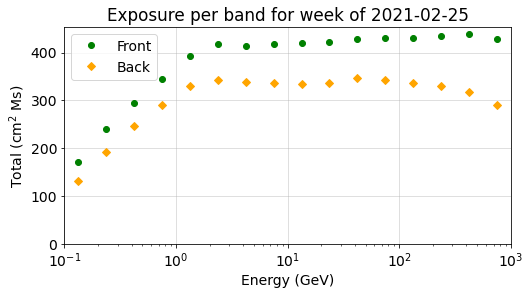

In [ ]:
#hide
config=Config(); config.verbose=2
if config.valid:
    source =PointSource('Geminga', config=config) 
    week_files = get_week_files(config, (665,665)); 
    week_file = week_files[0]


    self = ExposureMan(config, source, week_file)
#     self.hist_spacecraft()
    self.plot_exposure()
#     self.plot_photon_exposure()
#     self.hist_photons()

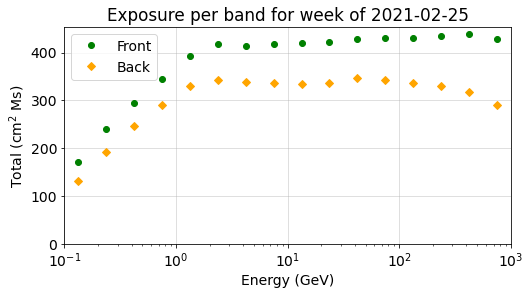

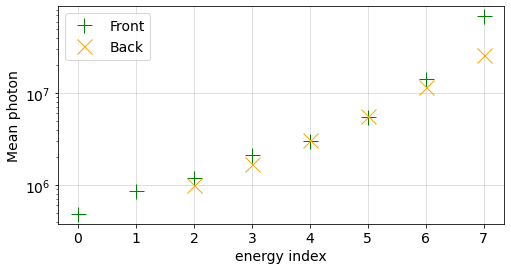

In [ ]:
(self.CAT[:,-1]/1e6).round(1)
self.plot_exposure()
self.plot_photon_exposure()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Thu Jul  8 07:24:55 PDT 2021


In [ ]:
import multiprocessing
from joblib import Parallel, delayed

ModuleNotFoundError: No module named 'joblib'

In [ ]:
multiprocessing.cpu_count()

8